In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from sklearn.metrics import average_precision_score
from torch.utils.tensorboard import SummaryWriter

In [3]:
from utils import do_train, predict_test

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
NAME_MODEL = 'VGG19_BN'

In [6]:
if torch.cuda.is_available():
    print('There is GPU')

There is GPU


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
CANTIDAD_CLASES = 2
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

In [9]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='P2datasetFull/train/', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='P2datasetFull/val1/', transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root='P2datasetFull/test1/', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [10]:
from torchvision.models.vgg import VGG19_BN_Weights
weights = VGG19_BN_Weights.IMAGENET1K_V1
transforms = weights.transforms()

model = torchvision.models.vgg19_bn(weights=weights)

model.to(device)

torchsummary.summary(model, input_size=(3, 224, 224))
model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [11]:
for param in model.parameters():
    param.requires_grad = False

In [12]:
last_layer_in_features = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

In [13]:
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loss = torch.nn.CrossEntropyLoss()
model_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
model_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

model_writer = {"train": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_train"),
                "valid": SummaryWriter(log_dir=f"data_{NAME_MODEL}/{NAME_MODEL}_model_valid")}

history = do_train(model.to("cpu"), 
                model_optimizer, 
                model_loss, 
                model_metric,
                model_data,
                20,
                device,
                model_writer)

Epoch: 1/20 - Train loss 0.341846 - Train Accuracy 0.875159 - Valid Loss 0.223846 - Valid Accuracy 0.923977
Epoch: 2/20 - Train loss 0.205186 - Train Accuracy 0.928571 - Valid Loss 0.190440 - Valid Accuracy 0.926849
Epoch: 3/20 - Train loss 0.182483 - Train Accuracy 0.929136 - Valid Loss 0.175950 - Valid Accuracy 0.931410
Epoch: 4/20 - Train loss 0.174783 - Train Accuracy 0.935354 - Valid Loss 0.170186 - Valid Accuracy 0.930621
Epoch: 5/20 - Train loss 0.164273 - Train Accuracy 0.936556 - Valid Loss 0.166312 - Valid Accuracy 0.931817
Epoch: 6/20 - Train loss 0.159964 - Train Accuracy 0.937586 - Valid Loss 0.161674 - Valid Accuracy 0.934615
Epoch: 7/20 - Train loss 0.151341 - Train Accuracy 0.944515 - Valid Loss 0.159642 - Valid Accuracy 0.936859
Epoch: 8/20 - Train loss 0.149574 - Train Accuracy 0.944515 - Valid Loss 0.158514 - Valid Accuracy 0.936464
Epoch: 9/20 - Train loss 0.149671 - Train Accuracy 0.944442 - Valid Loss 0.155909 - Valid Accuracy 0.939596
Epoch: 10/20 - Train loss 0.

In [14]:
torch.save(model.state_dict(), f'{NAME_MODEL}.pth')

In [15]:
# load
# model = MyModelDefinition(args)
# model.load_state_dict(torch.load('load/from/path/model.pth'))

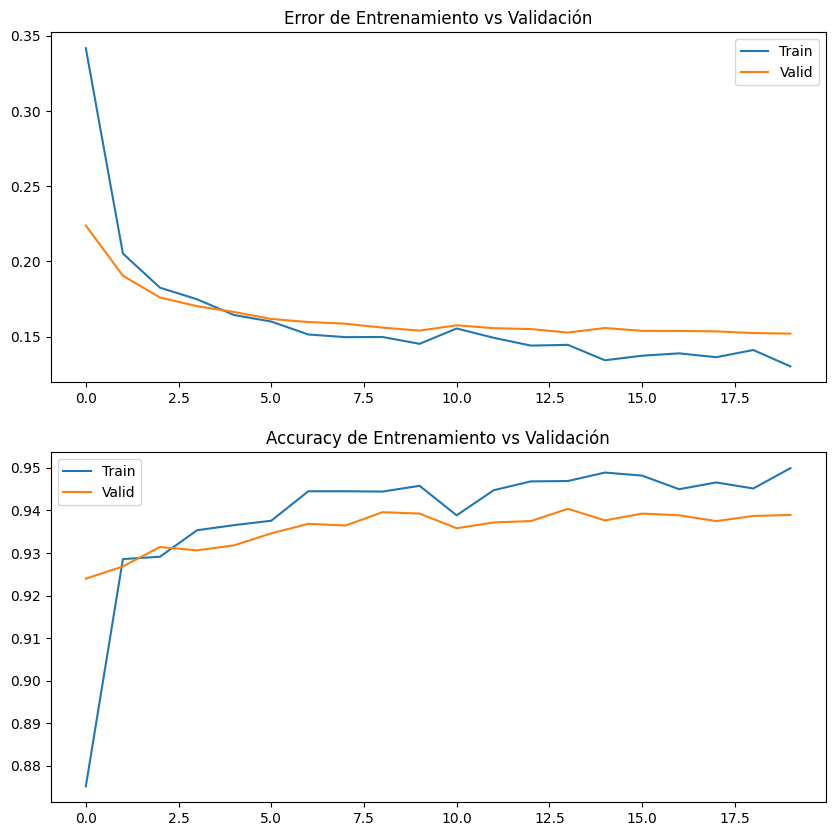

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [18]:
predict_test(model, test_loader)

Total images: 6216
PR_AUC: 0.9864586591438128
Accuracy: 94.11196911196912
